In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Visualizing Coarse damage

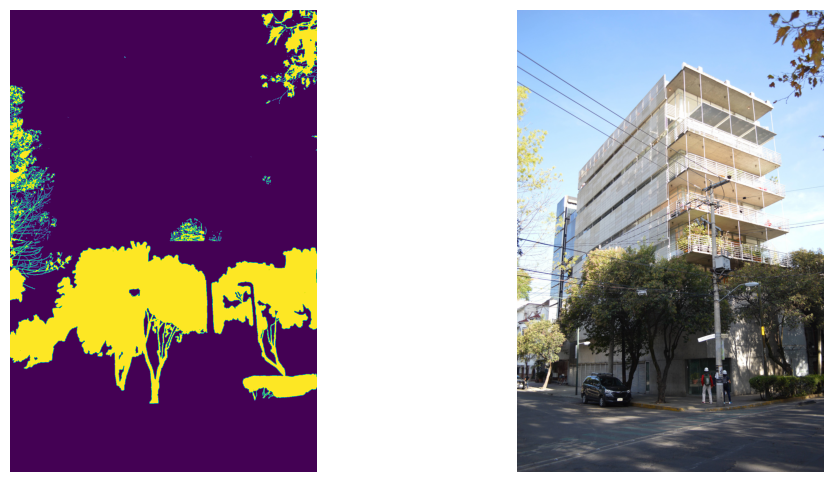

In [2]:
im1 = Image.open('Damage dataset/imageDamage/CoarseDamagePNG/01_RCB0017_F01_DSC_0076000.png')
im2 = Image.open('Damage dataset/imageDamage/imageDamage/01_RCB0017_F01_DSC_0076000.jpg')
image1 = np.array(im1)
image2 = np.array(im2)

# Create a 1x2 grid of subplots
plt.figure(figsize=(12, 6))  # Set the figure size
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(image1)  # Display the first image
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(image2)  # Display the second image
plt.axis('off')  # Hide the axis

plt.show()  # Show the plot


## Loading the Coarse damage dataset 

In [3]:
import torch 
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

class CustomSemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size = (1024,1024)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.num_classes = 8
        self.target_size = target_size
        
        

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

         # Resize the image and mask to the target size
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        mask_one_hot = torch.zeros((self.num_classes, self.target_size[1], self.target_size[0]), dtype=torch.float32)
        for class_idx in range(self.num_classes):
            mask_one_hot[class_idx] = (mask == class_idx)

        return image, mask_one_hot


In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms

# Define hyperparameters
batch_size = 8
learning_rate = 0.001
num_epochs = 10

# Define your custom dataset and data loaders
custom_dataset = CustomSemanticSegmentationDataset(image_dir='./Damage dataset/imageDamage/imageDamage', mask_dir='./Damage dataset/imageDamage/CoarseDamagePNG', transform=transforms.Compose([transforms.ToTensor()]), target_size=(1024, 1024))
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# Load a pre-trained model (e.g., ResNet-50)
#model = models.segmentation.fcn_resnet50(pretrained=True)
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
# Modify the model for your task
num_classes = custom_dataset.num_classes  # Adjust to the number of classes in your dataset
#model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    for inputs, masks in dataloader:
        total_loss = 0.0
        num_batches = 0

        inputs, masks = inputs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)['out']
        #print(outputs.shape)
        #print(masks.shape)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1

# Save the fine-tuned model
average_loss = total_loss / num_batches
print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")        
torch.save(model.state_dict(), 'fine_tuned_segmentation_model.pth')


/Users/sujitharavichandran/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sujitharavichandran/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt

# Load the fine-tuned model
#model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=num_classes)
model = models.segmentation.deeplabv3_resnet50(pretrained=True)  # Replace num_classes with the number of classes in your dataset
model.load_state_dict(torch.load('fine_tuned_segmentation_model.pth'))
model.eval()

# Load and preprocess the image for inference
image_path = 'path_to_your_image.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_image)

# Extract the predicted segmentation mask
predicted_mask = output['out'].argmax(1).squeeze().cpu().numpy()

# Visualize the predicted segmentation mask
plt.imshow(predicted_mask, cmap='jet')  # Use 'jet' colormap for segmentation masks
plt.axis('off')
plt.show()

# You can also save the predicted mask as an image if needed
# Save the predicted mask as an image
predicted_mask_image = Image.fromarray(predicted_mask.astype('uint8'))
predicted_mask_image.save('predicted_mask.png')
